In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [4]:
logging.info('abc')

08/16/2017 10:29:51 AM INFO: abc


In [5]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [6]:
LEN1=64*2
import Queue,random
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=LEN1
            len2=60
            j= random.randint(len1,len(row)-1)
            x=row[j-len1:j]
            part_y=row[j:j+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]= (part_y!=0)*1
            self.q.put((x.astype(np.float32),attrib_row.astype(np.float32),np.array(y,dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X1,X2, y,mask = self.q.get()
        self.curr_i += 1
        return X1,X2, y,mask 


In [7]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32, tf.float32], 
                                [(LEN1,), (12,), (60,),(60,)], batchsize, allow_smaller_final_batch=True),train_generator

In [8]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [9]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [10]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [11]:
def make_data():
    import pandas as pd
    csv_path="../input/newtrain_1.csv"
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [12]:
daily_data,attrib_data=make_data()

(145063, 550) (145063, 12)


In [13]:
print np.mean(daily_data==0)
#daily_data += (daily_data==0)*0.1
#print np.mean(daily_data==0)

0.0909115851232


In [14]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c,d= generator.next()
    #print a,b,c,d    
    print a.shape,b.shape,c.shape,d.shape


In [15]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [16]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b
from tensorflow.contrib import rnn
def lstm(x,x2, n_hiddens, n_input, n_output, scope):
    if 1:
        with tf.variable_scope(scope):
            x = tf.reshape(x, [-1, n_input])
            x = tf.split(x,n_input,1)
            basic_rnn_cells = [rnn.BasicLSTMCell(n_hidden) for n_hidden in n_hiddens]
            rnn_cell = rnn.MultiRNNCell(basic_rnn_cells)
            outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32) 
            concat_x=tf.concat([outputs[-1],x2],-1)
            print outputs[-1].get_shape(), concat_x.get_shape()             
            return concat_x

def get_Xy(x_size,x2_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    X2 = tf.placeholder("float", shape=[None, x2_size], name='input_x2')    
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X,X2, y,mask, l2_scale

In [17]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.X2, self.y, self.mask, self.l2_scale = get_Xy(x_size,12, y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer()#.minimize(self.loss)
                    gvs = self.optimizer.compute_gradients(self.loss)
                    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
                    self.train_op = self.optimizer.apply_gradients(capped_gvs)
        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            config = tf.ConfigProto(log_device_placement=True)
            config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
            self._session = tf.Session(graph=self.graph,config=config)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h = tf.log(X_raw+1)
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)
        
        h=lstm(h,self.X2, [n_hiddens[0]], x_size, y_size, 'lstm')
        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,y_size,'dense',with_activation=False)
        
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                predictions = tf.identity(logits_sum, name='prediction')
                float_labels = tf.cast(y, tf.float32)
                
                ratio=predictions/(float_labels+1e-4)
                additional_loss= 0.02*tf.cast(ratio>9,tf.float32)*tf.abs(ratio)\
                    +0.02*tf.cast(predictions<0.0,tf.float32)*tf.abs(predictions)
                additional_loss = tf.reduce_sum(additional_loss*self.mask)/tf.reduce_sum(self.mask)
                this_loss =  tf.abs(predictions-float_labels)/(tf.abs(predictions)+tf.abs(float_labels))
                this_loss=this_loss*self.mask
                this_loss = tf.identity(2* tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape')                          
                loss = this_loss + l2_loss+additional_loss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [18]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=5, y_size=2, n_hiddens=[2,2], l2_scale=0.1)
    model.initialize()
    #print [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [19]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [20]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, train_reader,test_reader, coord):
        count = 0
        loss = []; l2_loss = []
        while not coord.should_stop():
            try:
                if  True:
                    X,X2, y,mask = sess.run(train_reader)
                    feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa = model.session.run([model.train_op, model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    l2_loss.append(aa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, smape: {}'.format(
                            n_epoch, count, np.mean(loss), np.mean(l2_loss)))
                        loss = []; l2_loss = []
                        #self.read_params()

                    if count >= self.net_train_eval_intev:
                        X,X2, y,mask = sess.run(test_reader)
                        feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                        a, aa = model.session.run([ model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                        logging.info ('[epoch {}] Valid LOSS: {}, smape: {}'.format(
                            n_epoch, a, aa))
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        idx=np.random.permutation(range(len(daily_data)))
        trainidx=idx[:int(len(idx)*0.8)]
        testidx=idx[int(len(idx)*0.8):]
        train_daily_data=daily_data[trainidx]
        train_attrib_data=attrib_data[trainidx]
        test_daily_data=daily_data[testidx]
        test_attrib_data=attrib_data[testidx] 
        print train_daily_data.shape,test_daily_data.shape
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(train_daily_data,train_attrib_data,batchsize=batch_size,nrows=None)            
            test_reader,_ = make_train_readers(test_daily_data,test_attrib_data,batchsize=batch_size*20,nrows=None)            
            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader, test_reader,coord) is None:
                        raise Exception("train error") 
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [21]:
daily_data.shape

(145063, 550)

In [22]:
l2_scale = 1e-8*0

batch_size = 256

if 0: #test
    n_hiddens=[10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[512,512]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [23]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=LEN1, y_size=60, n_hiddens=n_hiddens, prefix='tmp_pred60_lstm_512_nozero_xnopad', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

08/16/2017 10:30:09 AM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
08/16/2017 10:30:09 AM INFO: MyModel logits shape (?, 60)


(?, 512) (?, 524)
(?, 512)
(?, 512)
(?, 60)


08/16/2017 10:30:22 AM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 256
08/16/2017 10:30:22 AM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 5120
08/16/2017 10:30:22 AM INFO: [epoch 0] start net training


(116050, 550) (29013, 550)
(116050, 550) (116050, 12)
(29013, 550) (29013, 12)


08/16/2017 10:30:41 AM INFO: [epoch 0][step 25600] AVG LOSS: 1.49241030216, smape: 1.48699259758
08/16/2017 10:30:54 AM INFO: [epoch 0][step 51200] AVG LOSS: 1.40786373615, smape: 1.39148497581
08/16/2017 10:31:08 AM INFO: [epoch 0][step 76800] AVG LOSS: 1.38544285297, smape: 1.35981595516
08/16/2017 10:31:22 AM INFO: [epoch 0][step 102400] AVG LOSS: 1.38028717041, smape: 1.34628891945
08/16/2017 10:31:35 AM INFO: [epoch 0][step 128000] AVG LOSS: 1.37347137928, smape: 1.33270871639
08/16/2017 10:31:48 AM INFO: [epoch 0][step 153600] AVG LOSS: 1.37248134613, smape: 1.32548141479
08/16/2017 10:32:02 AM INFO: [epoch 0][step 179200] AVG LOSS: 1.36774814129, smape: 1.31560659409
08/16/2017 10:32:15 AM INFO: [epoch 0][step 204800] AVG LOSS: 1.37190937996, smape: 1.3138859272
08/16/2017 10:32:28 AM INFO: [epoch 0][step 230400] AVG LOSS: 1.36770415306, smape: 1.30590927601
08/16/2017 10:32:42 AM INFO: [epoch 0][step 256000] AVG LOSS: 1.36426317692, smape: 1.29941225052
08/16/2017 10:32:42 AM I

08/16/2017 10:47:08 AM INFO: [epoch 7][step 102400] AVG LOSS: 0.503941178322, smape: 0.502083897591
08/16/2017 10:47:21 AM INFO: [epoch 7][step 128000] AVG LOSS: 0.520639240742, smape: 0.519115805626
08/16/2017 10:47:34 AM INFO: [epoch 7][step 153600] AVG LOSS: 0.510786652565, smape: 0.509140014648
08/16/2017 10:47:46 AM INFO: [epoch 7][step 179200] AVG LOSS: 0.497297018766, smape: 0.495644301176
08/16/2017 10:47:59 AM INFO: [epoch 7][step 204800] AVG LOSS: 0.490732163191, smape: 0.489265859127
08/16/2017 10:48:12 AM INFO: [epoch 7][step 230400] AVG LOSS: 0.486335456371, smape: 0.485037147999
08/16/2017 10:48:26 AM INFO: [epoch 7][step 256000] AVG LOSS: 0.488811045885, smape: 0.487394839525
08/16/2017 10:48:26 AM INFO: [epoch 7] Valid LOSS: 0.488309234381, smape: 0.486964583397
08/16/2017 10:48:28 AM INFO: [epoch 8] start net training
08/16/2017 10:48:43 AM INFO: [epoch 8][step 25600] AVG LOSS: 0.481474846601, smape: 0.480107575655
08/16/2017 10:48:56 AM INFO: [epoch 8][step 51200] AVG

08/16/2017 11:03:09 AM INFO: [epoch 14][step 153600] AVG LOSS: 0.439692467451, smape: 0.438000828028
08/16/2017 11:03:22 AM INFO: [epoch 14][step 179200] AVG LOSS: 0.435540169477, smape: 0.434090524912
08/16/2017 11:03:35 AM INFO: [epoch 14][step 204800] AVG LOSS: 0.438859641552, smape: 0.436779886484
08/16/2017 11:03:48 AM INFO: [epoch 14][step 230400] AVG LOSS: 0.436912536621, smape: 0.435021281242
08/16/2017 11:04:01 AM INFO: [epoch 14][step 256000] AVG LOSS: 0.433898329735, smape: 0.43227404356
08/16/2017 11:04:01 AM INFO: [epoch 14] Valid LOSS: 0.441372156143, smape: 0.438327491283
08/16/2017 11:04:02 AM INFO: [epoch 15] start net training
08/16/2017 11:04:18 AM INFO: [epoch 15][step 25600] AVG LOSS: 0.434607475996, smape: 0.432853400707
08/16/2017 11:04:30 AM INFO: [epoch 15][step 51200] AVG LOSS: 0.435471355915, smape: 0.433596640825
08/16/2017 11:04:43 AM INFO: [epoch 15][step 76800] AVG LOSS: 0.432286441326, smape: 0.430694133043
08/16/2017 11:04:56 AM INFO: [epoch 15][step 10

08/16/2017 11:19:05 AM INFO: [epoch 21][step 204800] AVG LOSS: 0.420576512814, smape: 0.418872326612
08/16/2017 11:19:18 AM INFO: [epoch 21][step 230400] AVG LOSS: 0.419827193022, smape: 0.418508946896
08/16/2017 11:19:31 AM INFO: [epoch 21][step 256000] AVG LOSS: 0.418268203735, smape: 0.416841685772
08/16/2017 11:19:31 AM INFO: [epoch 21] Valid LOSS: 0.42289185524, smape: 0.419941812754
08/16/2017 11:19:33 AM INFO: [epoch 22] start net training
08/16/2017 11:19:48 AM INFO: [epoch 22][step 25600] AVG LOSS: 0.416648715734, smape: 0.415441960096
08/16/2017 11:20:00 AM INFO: [epoch 22][step 51200] AVG LOSS: 0.42188513279, smape: 0.420500844717
08/16/2017 11:20:13 AM INFO: [epoch 22][step 76800] AVG LOSS: 0.418579488993, smape: 0.416686505079
08/16/2017 11:20:26 AM INFO: [epoch 22][step 102400] AVG LOSS: 0.415755629539, smape: 0.414173722267
08/16/2017 11:20:39 AM INFO: [epoch 22][step 128000] AVG LOSS: 0.416639566422, smape: 0.415099591017
08/16/2017 11:20:52 AM INFO: [epoch 22][step 153

08/16/2017 11:35:00 AM INFO: [epoch 28][step 256000] AVG LOSS: 0.416184455156, smape: 0.4149094522
08/16/2017 11:35:00 AM INFO: [epoch 28] Valid LOSS: 0.419003397226, smape: 0.416562885046
08/16/2017 11:35:02 AM INFO: [epoch 29] start net training
08/16/2017 11:35:17 AM INFO: [epoch 29][step 25600] AVG LOSS: 0.413825422525, smape: 0.412150532007
08/16/2017 11:35:30 AM INFO: [epoch 29][step 51200] AVG LOSS: 0.410990983248, smape: 0.409761548042
08/16/2017 11:35:42 AM INFO: [epoch 29][step 76800] AVG LOSS: 0.411281347275, smape: 0.409643560648
08/16/2017 11:35:55 AM INFO: [epoch 29][step 102400] AVG LOSS: 0.410833328962, smape: 0.409353524446
08/16/2017 11:36:08 AM INFO: [epoch 29][step 128000] AVG LOSS: 0.41352969408, smape: 0.412159889936
08/16/2017 11:36:21 AM INFO: [epoch 29][step 153600] AVG LOSS: 0.413836300373, smape: 0.412298321724
08/16/2017 11:36:34 AM INFO: [epoch 29][step 179200] AVG LOSS: 0.41258880496, smape: 0.411116302013
08/16/2017 11:36:47 AM INFO: [epoch 29][step 20480

08/16/2017 11:50:28 AM INFO: [epoch 36] start net training
08/16/2017 11:50:43 AM INFO: [epoch 36][step 25600] AVG LOSS: 0.405729860067, smape: 0.403904110193
08/16/2017 11:50:55 AM INFO: [epoch 36][step 51200] AVG LOSS: 0.402670681477, smape: 0.400816619396
08/16/2017 11:51:08 AM INFO: [epoch 36][step 76800] AVG LOSS: 0.405138790607, smape: 0.403557181358
08/16/2017 11:51:21 AM INFO: [epoch 36][step 102400] AVG LOSS: 0.406441450119, smape: 0.405064076185
08/16/2017 11:51:34 AM INFO: [epoch 36][step 128000] AVG LOSS: 0.406381309032, smape: 0.404858082533
08/16/2017 11:51:47 AM INFO: [epoch 36][step 153600] AVG LOSS: 0.407825827599, smape: 0.406456232071
08/16/2017 11:52:00 AM INFO: [epoch 36][step 179200] AVG LOSS: 0.406022161245, smape: 0.404167085886
08/16/2017 11:52:13 AM INFO: [epoch 36][step 204800] AVG LOSS: 0.405787289143, smape: 0.40446922183
08/16/2017 11:52:26 AM INFO: [epoch 36][step 230400] AVG LOSS: 0.40436321497, smape: 0.4027518332
08/16/2017 11:52:38 AM INFO: [epoch 36]

08/16/2017 12:06:26 PM INFO: [epoch 43][step 51200] AVG LOSS: 0.399090498686, smape: 0.397923856974
08/16/2017 12:06:39 PM INFO: [epoch 43][step 76800] AVG LOSS: 0.401553601027, smape: 0.400527775288
08/16/2017 12:06:52 PM INFO: [epoch 43][step 102400] AVG LOSS: 0.400248080492, smape: 0.398943215609
08/16/2017 12:07:05 PM INFO: [epoch 43][step 128000] AVG LOSS: 0.399588137865, smape: 0.398248970509
08/16/2017 12:07:18 PM INFO: [epoch 43][step 153600] AVG LOSS: 0.400232762098, smape: 0.398642152548
08/16/2017 12:07:31 PM INFO: [epoch 43][step 179200] AVG LOSS: 0.399085849524, smape: 0.397601038218
08/16/2017 12:07:44 PM INFO: [epoch 43][step 204800] AVG LOSS: 0.396812438965, smape: 0.395503908396
08/16/2017 12:07:57 PM INFO: [epoch 43][step 230400] AVG LOSS: 0.398143589497, smape: 0.396683812141
08/16/2017 12:08:10 PM INFO: [epoch 43][step 256000] AVG LOSS: 0.402538985014, smape: 0.401389300823
08/16/2017 12:08:10 PM INFO: [epoch 43] Valid LOSS: 0.401585251093, smape: 0.400101721287
08/

08/16/2017 12:22:24 PM INFO: [epoch 50][step 102400] AVG LOSS: 0.399197846651, smape: 0.397979646921
08/16/2017 12:22:37 PM INFO: [epoch 50][step 128000] AVG LOSS: 0.396433591843, smape: 0.395084142685
08/16/2017 12:22:50 PM INFO: [epoch 50][step 153600] AVG LOSS: 0.400031447411, smape: 0.398783445358
08/16/2017 12:23:03 PM INFO: [epoch 50][step 179200] AVG LOSS: 0.397805213928, smape: 0.396723181009
08/16/2017 12:23:16 PM INFO: [epoch 50][step 204800] AVG LOSS: 0.397392004728, smape: 0.395894169807
08/16/2017 12:23:29 PM INFO: [epoch 50][step 230400] AVG LOSS: 0.399161607027, smape: 0.397643864155
08/16/2017 12:23:42 PM INFO: [epoch 50][step 256000] AVG LOSS: 0.396360039711, smape: 0.395314395428
08/16/2017 12:23:43 PM INFO: [epoch 50] Valid LOSS: 0.393735706806, smape: 0.391608506441
08/16/2017 12:23:44 PM INFO: [epoch 51] start net training
08/16/2017 12:23:59 PM INFO: [epoch 51][step 25600] AVG LOSS: 0.395922541618, smape: 0.394366413355
08/16/2017 12:24:12 PM INFO: [epoch 51][step

08/16/2017 12:38:20 PM INFO: [epoch 57][step 153600] AVG LOSS: 0.395279198885, smape: 0.394026309252
08/16/2017 12:38:33 PM INFO: [epoch 57][step 179200] AVG LOSS: 0.392621070147, smape: 0.391551464796
08/16/2017 12:38:46 PM INFO: [epoch 57][step 204800] AVG LOSS: 0.39753806591, smape: 0.396305054426
08/16/2017 12:38:58 PM INFO: [epoch 57][step 230400] AVG LOSS: 0.395427882671, smape: 0.39435300231
08/16/2017 12:39:11 PM INFO: [epoch 57][step 256000] AVG LOSS: 0.395667493343, smape: 0.393225520849
08/16/2017 12:39:12 PM INFO: [epoch 57] Valid LOSS: 0.398521959782, smape: 0.394440323114
08/16/2017 12:39:13 PM INFO: [epoch 58] start net training
08/16/2017 12:39:29 PM INFO: [epoch 58][step 25600] AVG LOSS: 0.397117167711, smape: 0.39535304904
08/16/2017 12:39:42 PM INFO: [epoch 58][step 51200] AVG LOSS: 0.395476162434, smape: 0.394423127174
08/16/2017 12:39:55 PM INFO: [epoch 58][step 76800] AVG LOSS: 0.395471036434, smape: 0.394224256277
08/16/2017 12:40:07 PM INFO: [epoch 58][step 1024

08/16/2017 12:54:19 PM INFO: [epoch 64][step 204800] AVG LOSS: 0.393067717552, smape: 0.391742348671
08/16/2017 12:54:32 PM INFO: [epoch 64][step 230400] AVG LOSS: 0.393958926201, smape: 0.392792344093
08/16/2017 12:54:45 PM INFO: [epoch 64][step 256000] AVG LOSS: 0.396734386683, smape: 0.39495742321
08/16/2017 12:54:46 PM INFO: [epoch 64] Valid LOSS: 0.388534575701, smape: 0.388036102057
08/16/2017 12:54:47 PM INFO: [epoch 65] start net training
08/16/2017 12:55:02 PM INFO: [epoch 65][step 25600] AVG LOSS: 0.393573880196, smape: 0.392008125782
08/16/2017 12:55:15 PM INFO: [epoch 65][step 51200] AVG LOSS: 0.394095778465, smape: 0.392721325159
08/16/2017 12:55:28 PM INFO: [epoch 65][step 76800] AVG LOSS: 0.393315464258, smape: 0.392411649227
08/16/2017 12:55:41 PM INFO: [epoch 65][step 102400] AVG LOSS: 0.392493098974, smape: 0.391097664833
08/16/2017 12:55:54 PM INFO: [epoch 65][step 128000] AVG LOSS: 0.392146021128, smape: 0.391209572554
08/16/2017 12:56:06 PM INFO: [epoch 65][step 15

08/16/2017 01:10:16 PM INFO: [epoch 71][step 256000] AVG LOSS: 0.394661992788, smape: 0.393234789371
08/16/2017 01:10:17 PM INFO: [epoch 71] Valid LOSS: 0.395608961582, smape: 0.393997550011
08/16/2017 01:10:18 PM INFO: [epoch 72] start net training
08/16/2017 01:10:33 PM INFO: [epoch 72][step 25600] AVG LOSS: 0.392326891422, smape: 0.391389071941
08/16/2017 01:10:46 PM INFO: [epoch 72][step 51200] AVG LOSS: 0.391713380814, smape: 0.390662848949
08/16/2017 01:10:59 PM INFO: [epoch 72][step 76800] AVG LOSS: 0.389615565538, smape: 0.388351023197
08/16/2017 01:11:12 PM INFO: [epoch 72][step 102400] AVG LOSS: 0.391355246305, smape: 0.389844179153
08/16/2017 01:11:24 PM INFO: [epoch 72][step 128000] AVG LOSS: 0.390571326017, smape: 0.389196306467
08/16/2017 01:11:37 PM INFO: [epoch 72][step 153600] AVG LOSS: 0.38984721899, smape: 0.388960540295
08/16/2017 01:11:50 PM INFO: [epoch 72][step 179200] AVG LOSS: 0.392218887806, smape: 0.390946418047
08/16/2017 01:12:03 PM INFO: [epoch 72][step 20

08/16/2017 01:25:48 PM INFO: [epoch 79] start net training
08/16/2017 01:26:03 PM INFO: [epoch 79][step 25600] AVG LOSS: 0.388665437698, smape: 0.387643396854
08/16/2017 01:26:16 PM INFO: [epoch 79][step 51200] AVG LOSS: 0.387999773026, smape: 0.386895477772
08/16/2017 01:26:29 PM INFO: [epoch 79][step 76800] AVG LOSS: 0.393059760332, smape: 0.391746520996
08/16/2017 01:26:42 PM INFO: [epoch 79][step 102400] AVG LOSS: 0.388850927353, smape: 0.387836962938
08/16/2017 01:26:54 PM INFO: [epoch 79][step 128000] AVG LOSS: 0.390860021114, smape: 0.389828026295
08/16/2017 01:27:07 PM INFO: [epoch 79][step 153600] AVG LOSS: 0.390559613705, smape: 0.389453470707
08/16/2017 01:27:21 PM INFO: [epoch 79][step 179200] AVG LOSS: 0.392672270536, smape: 0.391245931387
08/16/2017 01:27:34 PM INFO: [epoch 79][step 204800] AVG LOSS: 0.391054809093, smape: 0.389742165804
08/16/2017 01:27:46 PM INFO: [epoch 79][step 230400] AVG LOSS: 0.390020400286, smape: 0.389054864645
08/16/2017 01:27:59 PM INFO: [epoch

08/16/2017 01:41:45 PM INFO: [epoch 86][step 51200] AVG LOSS: 0.390606015921, smape: 0.389413923025
08/16/2017 01:41:58 PM INFO: [epoch 86][step 76800] AVG LOSS: 0.390753507614, smape: 0.389331102371
08/16/2017 01:42:11 PM INFO: [epoch 86][step 102400] AVG LOSS: 0.388069659472, smape: 0.386929214001
08/16/2017 01:42:24 PM INFO: [epoch 86][step 128000] AVG LOSS: 0.38970425725, smape: 0.388677507639
08/16/2017 01:42:37 PM INFO: [epoch 86][step 153600] AVG LOSS: 0.388169586658, smape: 0.387114167213
08/16/2017 01:42:50 PM INFO: [epoch 86][step 179200] AVG LOSS: 0.390690207481, smape: 0.389505654573
08/16/2017 01:43:03 PM INFO: [epoch 86][step 204800] AVG LOSS: 0.389692604542, smape: 0.388825118542
08/16/2017 01:43:16 PM INFO: [epoch 86][step 230400] AVG LOSS: 0.388883143663, smape: 0.387795954943
08/16/2017 01:43:29 PM INFO: [epoch 86][step 256000] AVG LOSS: 0.389286130667, smape: 0.388209104538
08/16/2017 01:43:29 PM INFO: [epoch 86] Valid LOSS: 0.396720767021, smape: 0.395645081997
08/1

08/16/2017 01:57:40 PM INFO: [epoch 93][step 102400] AVG LOSS: 0.388135135174, smape: 0.386760562658
08/16/2017 01:57:53 PM INFO: [epoch 93][step 128000] AVG LOSS: 0.387950330973, smape: 0.387029647827
08/16/2017 01:58:06 PM INFO: [epoch 93][step 153600] AVG LOSS: 0.390510112047, smape: 0.389176130295
08/16/2017 01:58:19 PM INFO: [epoch 93][step 179200] AVG LOSS: 0.386470019817, smape: 0.38530638814
08/16/2017 01:58:31 PM INFO: [epoch 93][step 204800] AVG LOSS: 0.388232499361, smape: 0.387023210526
08/16/2017 01:58:44 PM INFO: [epoch 93][step 230400] AVG LOSS: 0.38680562377, smape: 0.386092066765
08/16/2017 01:58:57 PM INFO: [epoch 93][step 256000] AVG LOSS: 0.389158219099, smape: 0.387933820486
08/16/2017 01:58:57 PM INFO: [epoch 93] Valid LOSS: 0.393189877272, smape: 0.392047464848
08/16/2017 01:58:58 PM INFO: [epoch 94] start net training
08/16/2017 01:59:14 PM INFO: [epoch 94][step 25600] AVG LOSS: 0.388665616512, smape: 0.387546390295
08/16/2017 01:59:27 PM INFO: [epoch 94][step 5

08/16/2017 02:13:38 PM INFO: [epoch 100][step 153600] AVG LOSS: 0.39010643959, smape: 0.389184296131
08/16/2017 02:13:51 PM INFO: [epoch 100][step 179200] AVG LOSS: 0.38825443387, smape: 0.386626631021
08/16/2017 02:14:04 PM INFO: [epoch 100][step 204800] AVG LOSS: 0.387879937887, smape: 0.386800736189
08/16/2017 02:14:17 PM INFO: [epoch 100][step 230400] AVG LOSS: 0.388156294823, smape: 0.386818170547
08/16/2017 02:14:29 PM INFO: [epoch 100][step 256000] AVG LOSS: 0.389535307884, smape: 0.387899518013
08/16/2017 02:14:30 PM INFO: [epoch 100] Valid LOSS: 0.397013098001, smape: 0.395632326603
08/16/2017 02:14:31 PM INFO: [epoch 101] start net training
08/16/2017 02:14:47 PM INFO: [epoch 101][step 25600] AVG LOSS: 0.387978464365, smape: 0.386503607035
08/16/2017 02:14:59 PM INFO: [epoch 101][step 51200] AVG LOSS: 0.388434171677, smape: 0.387234389782
08/16/2017 02:15:12 PM INFO: [epoch 101][step 76800] AVG LOSS: 0.386684566736, smape: 0.385719329119
08/16/2017 02:15:25 PM INFO: [epoch 10

08/16/2017 02:29:18 PM INFO: [epoch 107][step 179200] AVG LOSS: 0.387840539217, smape: 0.386955797672
08/16/2017 02:29:31 PM INFO: [epoch 107][step 204800] AVG LOSS: 0.387991726398, smape: 0.386339753866
08/16/2017 02:29:44 PM INFO: [epoch 107][step 230400] AVG LOSS: 0.387233644724, smape: 0.386249631643
08/16/2017 02:29:57 PM INFO: [epoch 107][step 256000] AVG LOSS: 0.385408520699, smape: 0.384387582541
08/16/2017 02:29:58 PM INFO: [epoch 107] Valid LOSS: 0.393858969212, smape: 0.392799407244
08/16/2017 02:29:59 PM INFO: [epoch 108] start net training
08/16/2017 02:30:14 PM INFO: [epoch 108][step 25600] AVG LOSS: 0.387577593327, smape: 0.3861066401
08/16/2017 02:30:27 PM INFO: [epoch 108][step 51200] AVG LOSS: 0.387546032667, smape: 0.38646069169
08/16/2017 02:30:40 PM INFO: [epoch 108][step 76800] AVG LOSS: 0.383987009525, smape: 0.382867157459
08/16/2017 02:30:54 PM INFO: [epoch 108][step 102400] AVG LOSS: 0.386535793543, smape: 0.385195910931
08/16/2017 02:31:07 PM INFO: [epoch 108

08/16/2017 02:45:00 PM INFO: [epoch 114][step 204800] AVG LOSS: 0.385318398476, smape: 0.384438216686
08/16/2017 02:45:13 PM INFO: [epoch 114][step 230400] AVG LOSS: 0.385487377644, smape: 0.384062111378
08/16/2017 02:45:26 PM INFO: [epoch 114][step 256000] AVG LOSS: 0.387795835733, smape: 0.385891616344
08/16/2017 02:45:27 PM INFO: [epoch 114] Valid LOSS: 0.392849981785, smape: 0.39154317975
08/16/2017 02:45:28 PM INFO: [epoch 115] start net training
08/16/2017 02:45:43 PM INFO: [epoch 115][step 25600] AVG LOSS: 0.388180911541, smape: 0.387284249067
08/16/2017 02:45:56 PM INFO: [epoch 115][step 51200] AVG LOSS: 0.38784173131, smape: 0.386556118727
08/16/2017 02:46:09 PM INFO: [epoch 115][step 76800] AVG LOSS: 0.388002902269, smape: 0.386958479881
08/16/2017 02:46:22 PM INFO: [epoch 115][step 102400] AVG LOSS: 0.384769439697, smape: 0.383484125137
08/16/2017 02:46:35 PM INFO: [epoch 115][step 128000] AVG LOSS: 0.388264417648, smape: 0.386850386858
08/16/2017 02:46:48 PM INFO: [epoch 11

08/16/2017 03:00:43 PM INFO: [epoch 121][step 230400] AVG LOSS: 0.386452704668, smape: 0.385170787573
08/16/2017 03:00:56 PM INFO: [epoch 121][step 256000] AVG LOSS: 0.384044080973, smape: 0.383018761873
08/16/2017 03:00:57 PM INFO: [epoch 121] Valid LOSS: 0.381248652935, smape: 0.380120962858
08/16/2017 03:00:58 PM INFO: [epoch 122] start net training
08/16/2017 03:01:13 PM INFO: [epoch 122][step 25600] AVG LOSS: 0.386817127466, smape: 0.385992139578
08/16/2017 03:01:26 PM INFO: [epoch 122][step 51200] AVG LOSS: 0.387391805649, smape: 0.386319547892
08/16/2017 03:01:38 PM INFO: [epoch 122][step 76800] AVG LOSS: 0.385723829269, smape: 0.384396404028
08/16/2017 03:01:51 PM INFO: [epoch 122][step 102400] AVG LOSS: 0.384197890759, smape: 0.382956385612
08/16/2017 03:02:04 PM INFO: [epoch 122][step 128000] AVG LOSS: 0.383864551783, smape: 0.382807046175
08/16/2017 03:02:17 PM INFO: [epoch 122][step 153600] AVG LOSS: 0.386538416147, smape: 0.385124593973
08/16/2017 03:02:30 PM INFO: [epoch 

08/16/2017 03:16:26 PM INFO: [epoch 128][step 256000] AVG LOSS: 0.38311329484, smape: 0.382350951433
08/16/2017 03:16:27 PM INFO: [epoch 128] Valid LOSS: 0.382223039865, smape: 0.378678292036
08/16/2017 03:16:28 PM INFO: [epoch 129] start net training
08/16/2017 03:16:43 PM INFO: [epoch 129][step 25600] AVG LOSS: 0.386015236378, smape: 0.385133296251
08/16/2017 03:16:56 PM INFO: [epoch 129][step 51200] AVG LOSS: 0.383394271135, smape: 0.382525622845
08/16/2017 03:17:09 PM INFO: [epoch 129][step 76800] AVG LOSS: 0.385514765978, smape: 0.384505242109
08/16/2017 03:17:21 PM INFO: [epoch 129][step 102400] AVG LOSS: 0.384152799845, smape: 0.383134961128
08/16/2017 03:17:34 PM INFO: [epoch 129][step 128000] AVG LOSS: 0.385115325451, smape: 0.384392350912
08/16/2017 03:17:47 PM INFO: [epoch 129][step 153600] AVG LOSS: 0.386314570904, smape: 0.385196715593
08/16/2017 03:18:00 PM INFO: [epoch 129][step 179200] AVG LOSS: 0.383069902658, smape: 0.3819462955
08/16/2017 03:18:13 PM INFO: [epoch 129

08/16/2017 03:31:54 PM INFO: [epoch 135] Valid LOSS: 0.38136652112, smape: 0.380627989769
08/16/2017 03:31:55 PM INFO: [epoch 136] start net training
08/16/2017 03:32:10 PM INFO: [epoch 136][step 25600] AVG LOSS: 0.386728972197, smape: 0.385254979134
08/16/2017 03:32:23 PM INFO: [epoch 136][step 51200] AVG LOSS: 0.384649425745, smape: 0.38352650404
08/16/2017 03:32:36 PM INFO: [epoch 136][step 76800] AVG LOSS: 0.383277118206, smape: 0.382388621569
08/16/2017 03:32:49 PM INFO: [epoch 136][step 102400] AVG LOSS: 0.387806981802, smape: 0.386400878429
08/16/2017 03:33:01 PM INFO: [epoch 136][step 128000] AVG LOSS: 0.385823696852, smape: 0.384818434715
08/16/2017 03:33:14 PM INFO: [epoch 136][step 153600] AVG LOSS: 0.383699387312, smape: 0.382737666368
08/16/2017 03:33:27 PM INFO: [epoch 136][step 179200] AVG LOSS: 0.382346451283, smape: 0.38150537014
08/16/2017 03:33:40 PM INFO: [epoch 136][step 204800] AVG LOSS: 0.384679019451, smape: 0.383713573217
08/16/2017 03:33:53 PM INFO: [epoch 136

08/16/2017 03:47:25 PM INFO: [epoch 143] start net training
08/16/2017 03:47:40 PM INFO: [epoch 143][step 25600] AVG LOSS: 0.383949458599, smape: 0.382657647133
08/16/2017 03:47:53 PM INFO: [epoch 143][step 51200] AVG LOSS: 0.383719623089, smape: 0.382461816072
08/16/2017 03:48:06 PM INFO: [epoch 143][step 76800] AVG LOSS: 0.382658600807, smape: 0.381402939558
08/16/2017 03:48:19 PM INFO: [epoch 143][step 102400] AVG LOSS: 0.383048832417, smape: 0.382319182158
08/16/2017 03:48:32 PM INFO: [epoch 143][step 128000] AVG LOSS: 0.384264409542, smape: 0.383143156767
08/16/2017 03:48:45 PM INFO: [epoch 143][step 153600] AVG LOSS: 0.3832013309, smape: 0.38213044405
08/16/2017 03:48:58 PM INFO: [epoch 143][step 179200] AVG LOSS: 0.383505165577, smape: 0.382418900728
08/16/2017 03:49:10 PM INFO: [epoch 143][step 204800] AVG LOSS: 0.38430160284, smape: 0.383522808552
08/16/2017 03:49:23 PM INFO: [epoch 143][step 230400] AVG LOSS: 0.382632553577, smape: 0.3817717731
08/16/2017 03:49:36 PM INFO: [e

08/16/2017 04:03:12 PM INFO: [epoch 150][step 25600] AVG LOSS: 0.384738117456, smape: 0.383788943291
08/16/2017 04:03:25 PM INFO: [epoch 150][step 51200] AVG LOSS: 0.380481302738, smape: 0.379243403673
08/16/2017 04:03:37 PM INFO: [epoch 150][step 76800] AVG LOSS: 0.382277220488, smape: 0.381574600935
08/16/2017 04:03:50 PM INFO: [epoch 150][step 102400] AVG LOSS: 0.387686342001, smape: 0.386061787605
08/16/2017 04:04:03 PM INFO: [epoch 150][step 128000] AVG LOSS: 0.381330311298, smape: 0.380275756121
08/16/2017 04:04:15 PM INFO: [epoch 150][step 153600] AVG LOSS: 0.382126659155, smape: 0.381269752979
08/16/2017 04:04:28 PM INFO: [epoch 150][step 179200] AVG LOSS: 0.383310884237, smape: 0.382273107767
08/16/2017 04:04:41 PM INFO: [epoch 150][step 204800] AVG LOSS: 0.382065206766, smape: 0.381017565727
08/16/2017 04:04:54 PM INFO: [epoch 150][step 230400] AVG LOSS: 0.382233172655, smape: 0.380665659904
08/16/2017 04:05:07 PM INFO: [epoch 150][step 256000] AVG LOSS: 0.386325269938, smape

08/16/2017 04:18:53 PM INFO: [epoch 157][step 51200] AVG LOSS: 0.385108709335, smape: 0.383392512798
08/16/2017 04:19:06 PM INFO: [epoch 157][step 76800] AVG LOSS: 0.382135272026, smape: 0.381099700928
08/16/2017 04:19:19 PM INFO: [epoch 157][step 102400] AVG LOSS: 0.383380174637, smape: 0.382295012474
08/16/2017 04:19:31 PM INFO: [epoch 157][step 128000] AVG LOSS: 0.38219588995, smape: 0.381387293339
08/16/2017 04:19:44 PM INFO: [epoch 157][step 153600] AVG LOSS: 0.382835000753, smape: 0.381814956665
08/16/2017 04:19:57 PM INFO: [epoch 157][step 179200] AVG LOSS: 0.381315767765, smape: 0.380190312862
08/16/2017 04:20:10 PM INFO: [epoch 157][step 204800] AVG LOSS: 0.380761444569, smape: 0.379279434681
08/16/2017 04:20:22 PM INFO: [epoch 157][step 230400] AVG LOSS: 0.384020119905, smape: 0.382317841053
08/16/2017 04:20:35 PM INFO: [epoch 157][step 256000] AVG LOSS: 0.380093663931, smape: 0.379025906324
08/16/2017 04:20:36 PM INFO: [epoch 157] Valid LOSS: 0.379707843065, smape: 0.3780016

08/16/2017 04:34:36 PM INFO: [epoch 164][step 76800] AVG LOSS: 0.382830858231, smape: 0.381727665663
08/16/2017 04:34:49 PM INFO: [epoch 164][step 102400] AVG LOSS: 0.381954163313, smape: 0.381135851145
08/16/2017 04:35:02 PM INFO: [epoch 164][step 128000] AVG LOSS: 0.384290337563, smape: 0.383348912001
08/16/2017 04:35:15 PM INFO: [epoch 164][step 153600] AVG LOSS: 0.382779657841, smape: 0.381978958845
08/16/2017 04:35:28 PM INFO: [epoch 164][step 179200] AVG LOSS: 0.382317662239, smape: 0.381132155657
08/16/2017 04:35:41 PM INFO: [epoch 164][step 204800] AVG LOSS: 0.381302535534, smape: 0.380418628454
08/16/2017 04:35:54 PM INFO: [epoch 164][step 230400] AVG LOSS: 0.381741702557, smape: 0.380562484264
08/16/2017 04:36:06 PM INFO: [epoch 164][step 256000] AVG LOSS: 0.380204498768, smape: 0.379325300455
08/16/2017 04:36:07 PM INFO: [epoch 164] Valid LOSS: 0.386461764574, smape: 0.385054945946
08/16/2017 04:36:09 PM INFO: [epoch 165] start net training
08/16/2017 04:36:24 PM INFO: [epoc

08/16/2017 04:50:17 PM INFO: [epoch 171][step 102400] AVG LOSS: 0.382660359144, smape: 0.381425201893
08/16/2017 04:50:30 PM INFO: [epoch 171][step 128000] AVG LOSS: 0.382871866226, smape: 0.381782025099
08/16/2017 04:50:43 PM INFO: [epoch 171][step 153600] AVG LOSS: 0.382429689169, smape: 0.381070315838
08/16/2017 04:50:56 PM INFO: [epoch 171][step 179200] AVG LOSS: 0.382237613201, smape: 0.381207078695
08/16/2017 04:51:09 PM INFO: [epoch 171][step 204800] AVG LOSS: 0.382614225149, smape: 0.381412148476
08/16/2017 04:51:22 PM INFO: [epoch 171][step 230400] AVG LOSS: 0.381101697683, smape: 0.380374133587
08/16/2017 04:51:35 PM INFO: [epoch 171][step 256000] AVG LOSS: 0.382196784019, smape: 0.381183713675
08/16/2017 04:51:35 PM INFO: [epoch 171] Valid LOSS: 0.383757174015, smape: 0.382882118225
08/16/2017 04:51:37 PM INFO: [epoch 172] start net training
08/16/2017 04:51:52 PM INFO: [epoch 172][step 25600] AVG LOSS: 0.379715502262, smape: 0.378747433424
08/16/2017 04:52:05 PM INFO: [epoc

08/16/2017 05:06:02 PM INFO: [epoch 178][step 128000] AVG LOSS: 0.381562143564, smape: 0.380319744349
08/16/2017 05:06:15 PM INFO: [epoch 178][step 153600] AVG LOSS: 0.380365371704, smape: 0.379684478045
08/16/2017 05:06:28 PM INFO: [epoch 178][step 179200] AVG LOSS: 0.381940156221, smape: 0.380798757076
08/16/2017 05:06:41 PM INFO: [epoch 178][step 204800] AVG LOSS: 0.383134186268, smape: 0.382294744253
08/16/2017 05:06:53 PM INFO: [epoch 178][step 230400] AVG LOSS: 0.380238413811, smape: 0.379185169935
08/16/2017 05:07:06 PM INFO: [epoch 178][step 256000] AVG LOSS: 0.384100407362, smape: 0.382932573557
08/16/2017 05:07:07 PM INFO: [epoch 178] Valid LOSS: 0.387060791254, smape: 0.385209232569
08/16/2017 05:07:08 PM INFO: [epoch 179] start net training
08/16/2017 05:07:23 PM INFO: [epoch 179][step 25600] AVG LOSS: 0.3848695755, smape: 0.383755683899
08/16/2017 05:07:36 PM INFO: [epoch 179][step 51200] AVG LOSS: 0.382194012403, smape: 0.381439983845
08/16/2017 05:07:49 PM INFO: [epoch 1

08/16/2017 05:21:44 PM INFO: [epoch 185][step 153600] AVG LOSS: 0.382029801607, smape: 0.381274878979
08/16/2017 05:21:57 PM INFO: [epoch 185][step 179200] AVG LOSS: 0.381855607033, smape: 0.380804896355
08/16/2017 05:22:10 PM INFO: [epoch 185][step 204800] AVG LOSS: 0.379472047091, smape: 0.37827655673
08/16/2017 05:22:23 PM INFO: [epoch 185][step 230400] AVG LOSS: 0.382704049349, smape: 0.381542205811
08/16/2017 05:22:35 PM INFO: [epoch 185][step 256000] AVG LOSS: 0.379759192467, smape: 0.37877959013
08/16/2017 05:22:36 PM INFO: [epoch 185] Valid LOSS: 0.391364514828, smape: 0.389488816261
08/16/2017 05:22:37 PM INFO: [epoch 186] start net training
08/16/2017 05:22:53 PM INFO: [epoch 186][step 25600] AVG LOSS: 0.382559090853, smape: 0.38122984767
08/16/2017 05:23:06 PM INFO: [epoch 186][step 51200] AVG LOSS: 0.378130078316, smape: 0.377240985632
08/16/2017 05:23:19 PM INFO: [epoch 186][step 76800] AVG LOSS: 0.383760154247, smape: 0.382740616798
08/16/2017 05:23:32 PM INFO: [epoch 186

08/16/2017 05:37:27 PM INFO: [epoch 192][step 179200] AVG LOSS: 0.379512816668, smape: 0.378099948168
08/16/2017 05:37:40 PM INFO: [epoch 192][step 204800] AVG LOSS: 0.3802703619, smape: 0.378997415304
08/16/2017 05:37:53 PM INFO: [epoch 192][step 230400] AVG LOSS: 0.379506349564, smape: 0.378716737032
08/16/2017 05:38:06 PM INFO: [epoch 192][step 256000] AVG LOSS: 0.381318092346, smape: 0.380488097668
08/16/2017 05:38:06 PM INFO: [epoch 192] Valid LOSS: 0.378684818745, smape: 0.37769985199
08/16/2017 05:38:08 PM INFO: [epoch 193] start net training
08/16/2017 05:38:23 PM INFO: [epoch 193][step 25600] AVG LOSS: 0.382965266705, smape: 0.381697297096
08/16/2017 05:38:36 PM INFO: [epoch 193][step 51200] AVG LOSS: 0.381501078606, smape: 0.380534589291
08/16/2017 05:38:49 PM INFO: [epoch 193][step 76800] AVG LOSS: 0.380889445543, smape: 0.379767715931
08/16/2017 05:39:02 PM INFO: [epoch 193][step 102400] AVG LOSS: 0.383275270462, smape: 0.382183223963
08/16/2017 05:39:15 PM INFO: [epoch 193

08/16/2017 05:53:08 PM INFO: [epoch 199][step 204800] AVG LOSS: 0.380020529032, smape: 0.379152297974
08/16/2017 05:53:21 PM INFO: [epoch 199][step 230400] AVG LOSS: 0.381372451782, smape: 0.380306214094
08/16/2017 05:53:34 PM INFO: [epoch 199][step 256000] AVG LOSS: 0.38097256422, smape: 0.3798430264
08/16/2017 05:53:34 PM INFO: [epoch 199] Valid LOSS: 0.381566852331, smape: 0.380527466536
08/16/2017 05:53:36 PM INFO: BN request stop from train
08/16/2017 05:53:36 PM WARNING: GeneratorRunner exception: <class 'tensorflow.python.framework.errors_impl.CancelledError'>
08/16/2017 05:53:36 PM WARNING: GeneratorRunner exception: <class 'tensorflow.python.framework.errors_impl.CancelledError'>


# prediction

In [24]:
sess=tf.Session()

In [25]:
saver = tf.train.import_meta_graph('tmp_pred60_lstm_512_nozero_xnopad/model_0-0.meta')

In [26]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred60_lstm_512_nozero_xnopad/'))

INFO:tensorflow:Restoring parameters from tmp_pred60_lstm_512_nozero_xnopad/model_0-0


08/16/2017 06:33:45 PM INFO: Restoring parameters from tmp_pred60_lstm_512_nozero_xnopad/model_0-0


In [27]:
graph = tf.get_default_graph()

In [28]:
x = graph.get_tensor_by_name("input_x:0")
x2 = graph.get_tensor_by_name("input_x2:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [38]:
X=[];X2=[];Y=[];MASK=[]
for _ in range(10000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=128
    len2=60
    j=int(np.random.random()*(len(row)-len1-1))
    xx=row[j:j+len1]
    part_y=row[j+len1:j+len1+len2]
    yy=np.zeros(len2,dtype=np.float32)
    yy[:len(part_y)]=part_y
    mask=np.zeros(len2,dtype=np.float32)
    #mask[:len(part_y)]=1
    mask[:len(part_y)]=part_y>0
    a,aa,b,c= xx.astype(np.float32),attrib_row.astype(np.float32),np.array(yy,dtype=np.float32),mask
    X.append(a),X2.append(aa),Y.append(b),MASK.append(c)

In [39]:
X=np.array(X);X2=np.array(X2);Y=np.array(Y);MASK=np.array(MASK)
X.shape,X2.shape,Y.shape,MASK.shape

((10000, 128), (10000, 12), (10000, 60), (10000, 60))

In [40]:
feed_dict={x:X,x2:X2, y:Y,m:MASK,l2_scale:0}

In [41]:
sess.run(loss,feed_dict=feed_dict)

0.37754911

In [42]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(10000, 60)


In [43]:
a.max(),a.min()

(12237.426, 0.3666532)

In [44]:
this_loss =  2*np.abs(a-Y)/(np.abs(a)+np.abs(Y))
print np.sum(this_loss<=0)
this_loss=this_loss*MASK
print this_loss.sum()
this_loss.sum()/MASK.sum() 

0
196897.0


0.37754905

In [45]:
MASK.sum()

521514.0

In [46]:
lst=[]
for i in range(1000):
    u=Y[i]
    v=a[i]
    t=MASK[i]
    lst.append(((2*np.abs(u-v)/(np.abs(u)+np.abs(v)))).mean())
    #lst.append(((2*np.abs(v-u)/(np.abs(u)+np.abs(v)))*t).sum()  )  
lst=np.array(lst)
print np.sum(lst),lst.shape    

578.725 (1000,)


Populating the interactive namespace from numpy and matplotlib
0.578725


/home/bo/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


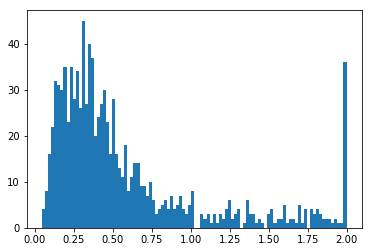

In [47]:
%pylab inline
plt.hist(lst,bins=100);
print np.mean(lst) 

968.0 900.687 0.126075


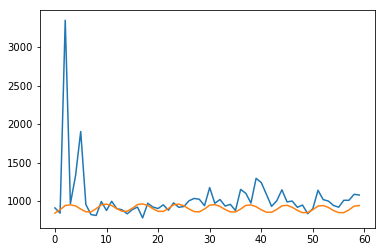

In [48]:
i=1233
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

In [49]:
daily_data.shape,attrib_data.shape

((145063, 550), (145063, 12))

In [50]:
daily_test=daily_data[:,-LEN1:]
attrib_test=attrib_data
daily_test.shape,attrib_test.shape

((145063, 128), (145063, 12))

In [51]:
feed_dict={x:daily_test,x2:attrib_test}
predTest=sess.run(prediction,feed_dict=feed_dict)
predTest.shape

(145063, 60)

In [52]:
predTest=np.round(predTest,1)
np.mean(predTest<1)

4.5267688291753696e-05

In [53]:
import datetime
cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d"))
idx=pd.read_csv("../input/train_1.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [54]:
submission=pd.DataFrame(predTest,columns=cols,index=idx)
submission=submission.unstack().reset_index()
submission['name']=submission.apply(lambda r: r['Page']+"_"+r['level_0'],axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['Visits','name']

In [55]:
submission=submission[["name",'Visits']]
submission.head()

name     Visits
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  18.600000
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  19.799999
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.900000
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.800000
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.200000

In [56]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)

In [57]:
keys_dict=keys["Id"].to_dict()

In [58]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

In [59]:
submission.isnull().sum().sum()

0L

In [60]:
submission.head()

name     Visits            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  18.600000  ff8c1aade3de
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  19.799999  3da6fd5b23c1
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.900000  cd9e83803be4
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.800000  65cd4af0968c
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.200000  75bae1fb2637

In [61]:
submission[["Id","Visits"]].to_csv("../submission/sub_pred_lstm1_60_512_nozero_xnopad.csv.gz",
                                   index=None, float_format='%.1f', compression="gzip")